In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import re
import string
import collections
from wordcloud import WordCloud

# Nltk
import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.sklearn

# Word2vec
import gensim

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Concatenate, Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Manifold learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

C:\Users\Vladi\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\Vladi\anaconda3\lib\site-packages\flatbuffers\compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
C:\Users\Vladi\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
C:\Users\Vladi\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
C:\Users\Vladi\anaconda3\lib\site-packages\keras_preprocessing\i

In [2]:
sns.set_style("dark")
sns.set_palette('crest')

In [3]:
# KERAS
sequence_length = 300
epochs = 10
batch_size = 128

# WORD2VEC 
w2v_size = 300
w2v_window = 7
w2v_epoch = 32
w2v_min_count = 10

# Glove
embedding_file = "C:\\JupyterNotebooks\\Modelos preentrenados\\GloVe\\glove.840B.300d.txt"
max_features = 2780
maxlen = 300
embedding_dim = 300

In [4]:
train = pd.read_csv("train.csv")
train.head()

,train_idx,text,label,label_text
0,0,i really do recommend this to anyone in need o...,1,positive
1,1,very good every day camera fits nicely in the ...,1,positive
2,2,"but , dollar for dollar , this dvd player is p...",1,positive
3,3,i got this phone yesterday and didn ' t find a...,1,positive
4,4,1 ) price gb of storage,1,positive


In [5]:
test = pd.read_csv("test.csv")
test.head()

,test_idx,text
0,0,fm receiver it has none
1,1,"the picture quality surprised me , when i firs..."
2,2,great video clip quality for a digital camera ...
3,3,creative did well on its rechargeable battery ...
4,4,i highly recommend this camera to anyone looki...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3016 entries, 0 to 3015
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   train_idx   3016 non-null   int64 
 1   text        3016 non-null   object
 2   label       3016 non-null   int64 
 3   label_text  3016 non-null   object
dtypes: int64(2), object(2)
memory usage: 94.4+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   test_idx  754 non-null    int64 
 1   text      754 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.9+ KB


In [8]:
train["label_text"].unique()

array(['positive', 'negative'], dtype=object)

Text(0.5, 1.0, 'Dataset labels distribuition')

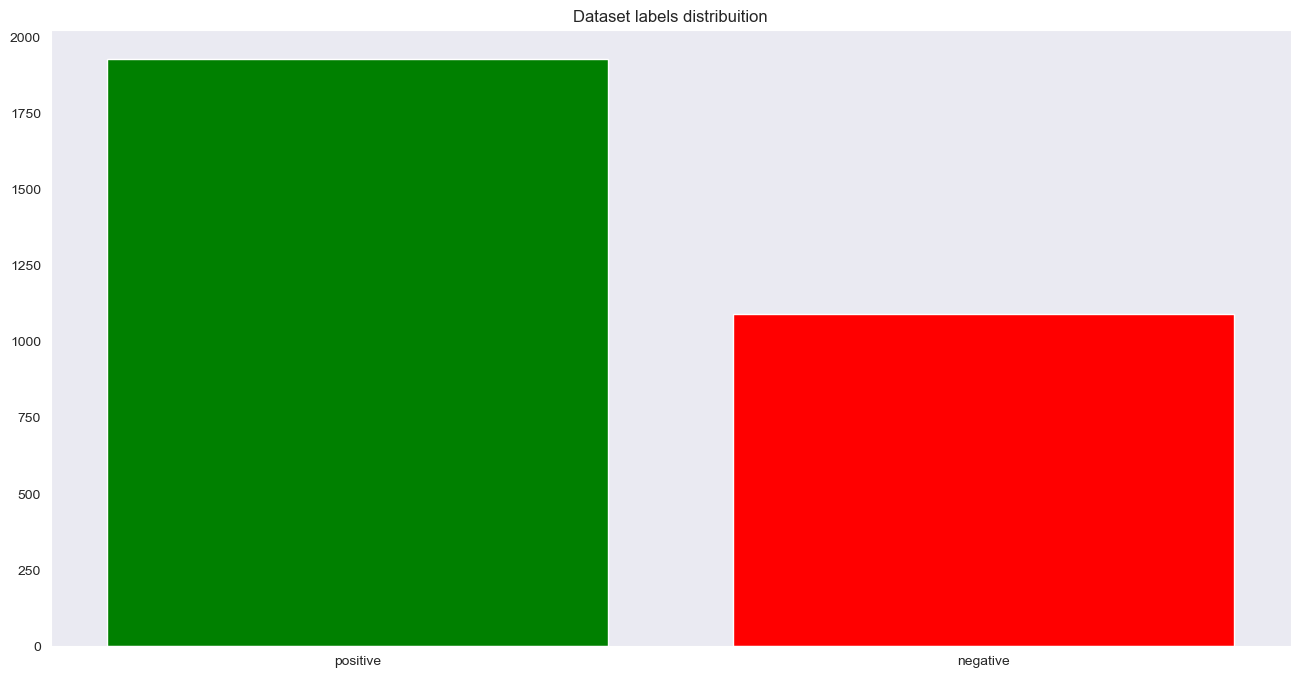

In [9]:
target_cnt = Counter(train.label_text)

# Define colors for positive and negative labels
pos_color = 'green'
neg_color = 'red'

# Create a list of colors based on label values
colors = [pos_color if label == 'positive' else neg_color for label in target_cnt.keys()]

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values(), color=colors)
plt.title("Dataset labels distribuition")

##### Preprocessing

In [10]:
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

In [11]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
C:\Users\Vladi\AppData\Local\Temp\ipykernel_5612\511036377.py:5: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
C:\Users\Vladi\AppData\Local\Temp\ipykernel_5612\511036377.py:6: DeprecationWarning: invalid escape sequence \S
  text = re.sub('https?://\S+|www\.\S+', '', text)
C:\Users\Vladi\AppData\Local\Temp\ipykernel_5612\511036377.py:10: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text)


In [12]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [13]:
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [14]:
def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in text.split()]
    return ' '.join(lemmatized_words)

In [15]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

In [16]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

In [17]:
train['clean_text'] = train['text'].apply(clean_text)
train['clean_text'] = train['clean_text'].apply(remove_stopwords)
# train['clean_text'] = train['clean_text'].apply(stemm_text)
train['clean_text'] = train['clean_text'].apply(lemmatize_text)
train['clean_text'] = train['clean_text'].apply(preprocess_data)

In [18]:
test['clean_text'] = test['text'].apply(clean_text)
test['clean_text'] = test['clean_text'].apply(remove_stopwords)
# test['clean_text'] = test['clean_text'].apply(stemm_text)
test['clean_text'] = test['clean_text'].apply(lemmatize_text)
test['clean_text'] = test['clean_text'].apply(preprocess_data)

In [19]:
train.head()

,train_idx,text,label,label_text,clean_text
0,0,i really do recommend this to anyone in need o...,1,positive,realli recommend anyon need new player
1,1,very good every day camera fits nicely in the ...,1,positive,good everi day camera fit nice pocket jean tak...
2,2,"but , dollar for dollar , this dvd player is p...",1,positive,dollar dollar dvd player probabl best
3,3,i got this phone yesterday and didn ' t find a...,1,positive,get phone yesterday find problem yet
4,4,1 ) price gb of storage,1,positive,price gb storag


##### Exploratory Data Analysis

In [20]:
train['message_len'] = train['clean_text'].apply(lambda x: len(x.split(' ')))
test['message_len'] = test['clean_text'].apply(lambda x: len(x.split(' ')))

In [21]:
train["message_len"].nunique()

35

In [22]:
train["message_len"].unique()

array([ 6, 11,  3,  5,  4,  7, 13,  9, 20,  8,  2, 17, 12, 21, 16, 10, 14,
        1, 18, 29, 19, 15, 27, 22, 23, 25, 28, 47, 30, 26, 34, 24, 31, 38,
       33], dtype=int64)

In [23]:
# Assuming "train" is the name of your DataFrame with "message_len" column
unique_values = sorted(train["message_len"].unique())
counts = train["message_len"].value_counts(sort=False)
# count = train.groupby(["message_len"])["message_len"].count()

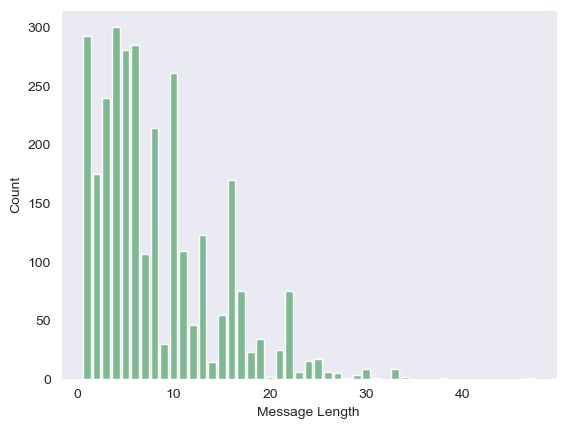

In [24]:
# Create a barplot
plt.bar(unique_values, counts)
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.show()

message_len based on label

In [25]:
# Assuming "train" is the name of your DataFrame with "message_len" and "label" columns
unique_values = sorted(train["message_len"].unique())
grouped_data = train.groupby(["label_text", "message_len"])["message_len"].count()

In [26]:
# Separate the grouped data by label
positive_counts = grouped_data["positive"].reindex(unique_values, fill_value=0)
negative_counts = grouped_data["negative"].reindex(unique_values, fill_value=0)

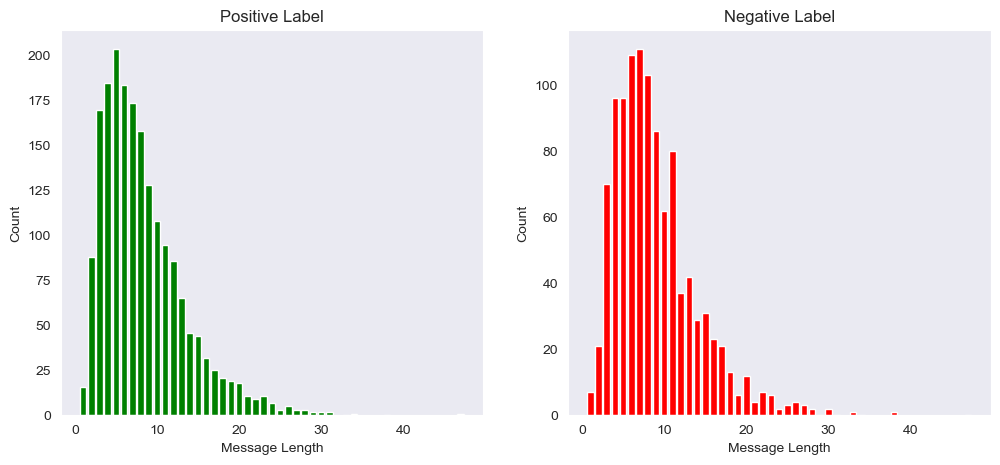

In [27]:
# Create separate barplots for positive and negative labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(unique_values, positive_counts, color='green')
ax1.set_xlabel("Message Length")
ax1.set_ylabel("Count")
ax1.set_title("Positive Label")

ax2.bar(unique_values, negative_counts, color='red')
ax2.set_xlabel("Message Length")
ax2.set_ylabel("Count")
ax2.set_title("Negative Label")

plt.show()

Word frequency analysis

In [28]:
words = train['clean_text'].str.split()

In [29]:
words = [word for sublist in words for word in sublist]

In [30]:
words

['realli',
 'recommend',
 'anyon',
 'need',
 'new',
 'player',
 'good',
 'everi',
 'day',
 'camera',
 'fit',
 'nice',
 'pocket',
 'jean',
 'take',
 'qualiti',
 'photo',
 'dollar',
 'dollar',
 'dvd',
 'player',
 'probabl',
 'best',
 'get',
 'phone',
 'yesterday',
 'find',
 'problem',
 'yet',
 'price',
 'gb',
 'storag',
 'one',
 'cabinet',
 'shop',
 'use',
 'one',
 'regular',
 'router',
 'tabl',
 'year',
 'without',
 'problem',
 'say',
 'os',
 'phone',
 'run',
 'issu',
 'model',
 'appear',
 'especi',
 'good',
 'find',
 'stabl',
 'hand',
 'weight',
 'actual',
 'contribut',
 'stabil',
 'catch',
 'play',
 'movi',
 'fine',
 'refus',
 'read',
 'second',
 'disc',
 'movi',
 'extra',
 'two',
 'occas',
 'tri',
 'con',
 'fm',
 'radio',
 'tuner',
 'someth',
 'larg',
 'number',
 'compet',
 'tor',
 'move',
 'focus',
 'rang',
 'almost',
 'anywher',
 'scene',
 'push',
 'button',
 'screen',
 'manual',
 'focus',
 'mode',
 'would',
 'realli',
 'help',
 'shoot',
 'scene',
 'tough',
 'automat',
 'focus',
 '

In [31]:
word_counts = collections.Counter(words)

In [32]:
for word, count in word_counts.most_common():
    print(word, count)

use 422
player 282
get 260
phone 256
camera 255
great 230
one 224
work 215
like 180
good 179
easi 172
featur 169
qualiti 167
problem 162
take 149
batteri 149
pictur 135
softwar 133
ipod 130
would 128
also 127
time 127
well 125
play 122
make 121
sound 121
n 112
look 112
router 111
zen 106
even 100
realli 98
product 98
find 97
price 95
thing 94
buy 92
diaper 91
come 91
go 90
better 89
littl 87
give 84
creativ 82
much 81
button 77
excel 77
best 76
still 76
need 75
nice 75
small 75
dvd 74
music 74
seem 74
screen 73
love 72
file 71
song 70
set 70
first 68
instal 67
comput 65
tri 63
want 63
say 62
lot 62
size 62
control 62
could 61
think 61
see 58
way 58
hard 58
far 57
mani 56
bite 55
read 54
support 54
month 53
servic 53
day 52
micro 52
case 52
digit 51
purchas 51
new 50
without 50
life 50
review 50
connect 49
transfer 49
program 49
easili 49
high 48
enough 48
bag 47
light 47
perfect 47
design 47
manual 46
long 46
headphon 46
nokia 46
big 45
mode 44
includ 44
champ 44
peopl 44
keep 43
start

In [33]:
corpus = ' '.join(train['clean_text'].tolist())

In [34]:
# Create a WordCloud object with parameters
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm', max_words=50)

In [35]:
# Generate the word cloud
wordcloud.generate(corpus)

C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:513: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wo

C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\an

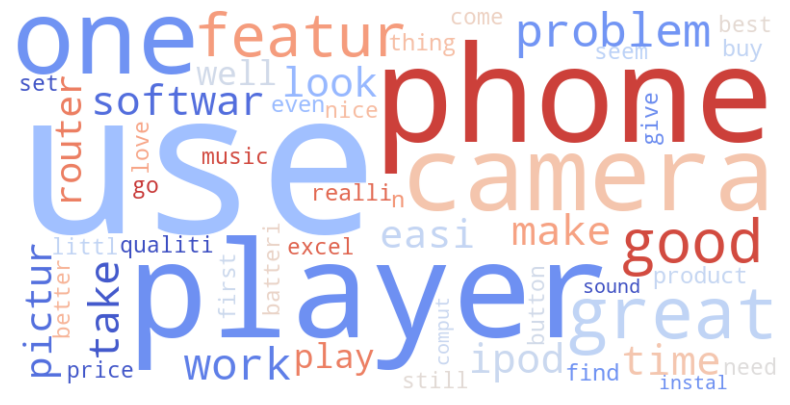

In [36]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [37]:
def plot_word_clouds(df, text_column, label_column):
    # Extract text for positive and negative examples
    positive_text = ' '.join(df[df[label_column] == 'positive'][text_column].tolist())
    negative_text = ' '.join(df[df[label_column] == 'negative'][text_column].tolist())

    # Create word clouds for positive and negative examples
    positive_cloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens', max_words=50)
    negative_cloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=50)

    positive_cloud.generate(positive_text)
    negative_cloud.generate(negative_text)

    # Plot word clouds side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(negative_cloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title('Negative Examples')
    axs[1].imshow(positive_cloud, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title('Positive Examples')
    
    plt.show()

C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=trans

C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\anaconda3\lib\site-packages\wordcloud\wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\Users\Vladi\an

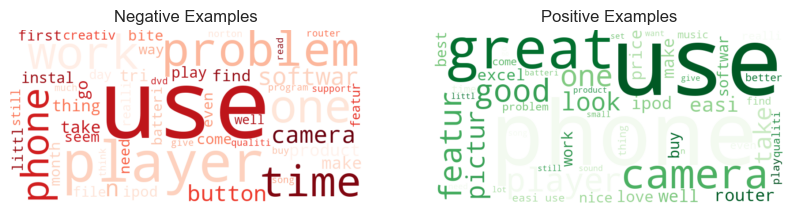

In [38]:
plot_word_clouds(train, "clean_text", "label_text")

N-gram analysis

In [39]:
def plot_ngrams(dataframe, text_col, n, n_most_common):
    '''
    Performs n-gram analysis on text data in a pandas dataframe column
    and visualizes the most common n-grams using a bar chart.

    Parameters:
        dataframe (pandas dataframe): Dataframe containing text data
        text_col (str): Name of column containing the text data
        n (int): Value of n for the n-grams (2 or 3)
        n_most_common (int): Number of most common n-grams to plot

    Returns:
        None
    '''

    # Tokenize the text in each row and generate n-grams
    n_grams_list = [] # To store all the n-grams from all the rows

    for i, row in dataframe.iterrows():
        text = row[text_col]
        tokens = nltk.word_tokenize(text)
        n_grams = ngrams(tokens, n)
        n_grams_list += n_grams

    # Count the frequency of each n-gram using Counter() from the collections module
    freq_dist = Counter(n_grams_list)

    # Visualize the most common n-grams using a bar chart
    most_common_ngrams = freq_dist.most_common(n_most_common)
    labels, values = zip(*most_common_ngrams)
    labels = [ ' '.join(label) for label in labels] # join the words in the label tuple
    plt.bar(labels, values)
    plt.xticks(rotation=90)
    plt.xlabel('N-gram')
    plt.ylabel('Frequency')
    plt.title(f'Top {n_most_common} most common {n}-grams in {text_col}')
    plt.show()

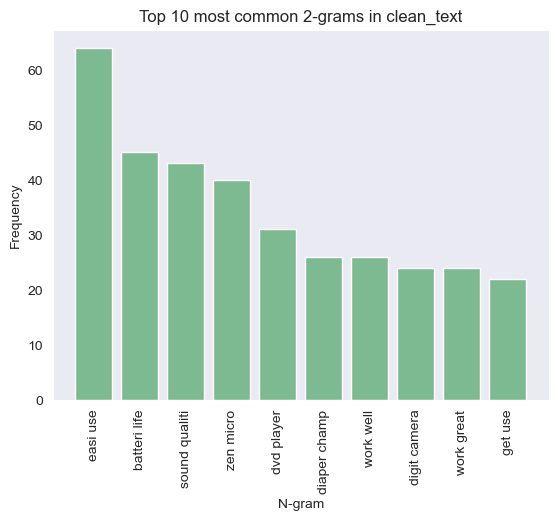

In [40]:
plot_ngrams(train, 'clean_text', 2, 10)

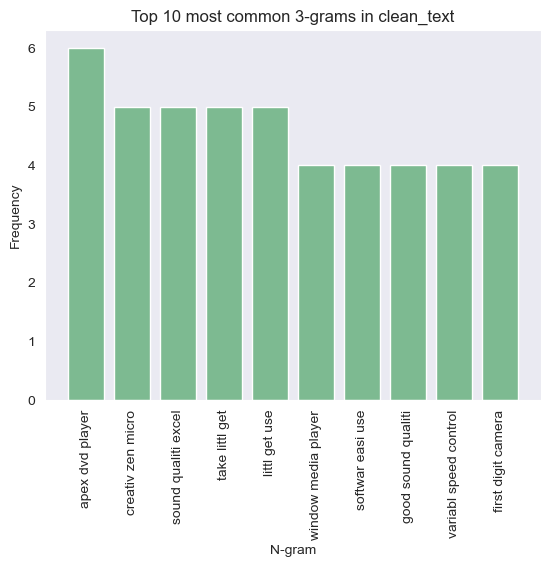

In [41]:
plot_ngrams(train, 'clean_text', 3, 10)

Part-of-speech analysis

In [43]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Vladi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [44]:
train['words'] = train['clean_text'].apply(word_tokenize)

In [45]:
train['pos_tags'] = train['words'].apply(pos_tag)

In [46]:
for i, row in train.iterrows():
    print(f"Row {i}:")
    for word, pos_tag in row['pos_tags']:
        print(word, pos_tag)

Row 0:
realli JJ
recommend NN
anyon NNS
need VBP
new JJ
player NN
Row 1:
good JJ
everi NN
day NN
camera NN
fit NN
nice JJ
pocket NN
jean JJ
take NN
qualiti NN
photo NN
Row 2:
dollar NN
dollar NN
dvd NN
player NN
probabl NN
best JJS
Row 3:
get VB
phone NN
yesterday NN
find VBP
problem NN
yet RB
Row 4:
price NN
gb NNS
storag VBP
Row 5:
one CD
cabinet NN
shop NN
use VBP
one CD
regular JJ
router NN
tabl NN
year NN
without IN
problem NN
Row 6:
say VB
os PRP
phone NN
run VB
issu NN
Row 7:
model NN
appear VB
especi RB
good JJ
Row 8:
find VB
stabl JJ
hand NN
weight VBD
actual JJ
contribut NN
stabil NN
Row 9:
catch NN
play NN
movi FW
fine JJ
refus NN
read JJ
second JJ
disc NN
movi NNS
extra JJ
two CD
occas NN
tri NN
Row 10:
con NN
fm NN
radio NN
tuner NN
someth VBZ
larg JJ
number NN
compet NN
tor NN
Row 11:
move NN
focus NN
rang VBD
almost RB
anywher JJ
scene NN
push NN
button NN
screen NN
manual JJ
focus NN
mode NN
would MD
realli VB
help NN
shoot VB
scene NN
tough JJ
automat NN
focus NN
Row 1

say VB
main JJ
problem NN
player NN
make VBP
well NN
Row 2509:
valu NN
compar NN
data NNS
storag NN
price NN
Row 2510:
small JJ
abl JJ
keep NN
pocket NN
fear NN
get VBP
ruin JJ
pocket NN
durabl NN
Row 2511:
ad NN
n NN
work NN
correct JJ
start NN
ad NN
last JJ
week NN
half JJ
start NN
act NN
Row 2512:
decent JJ
camera NN
phone NN
take VB
quick JJ
pictur NN
movi NN
general JJ
around IN
fun NN
Row 2513:
send VB
back RP
apex NN
wo MD
n VB
play NN
certain JJ
disney NN
dvd NN
movi NN
disc NN
messag NN
Row 2514:
problem NN
find NN
plung NN
mechan NN
eventu NN
stick NN
due JJ
wood NN
dust NN
Row 2515:
updat JJ
januari NN
second JJ
one CD
crap NN
week NN
dont JJ
buy NN
product NN
Row 2516:
get VB
player NN
Row 2517:
everyth NN
els NNS
ipod VBP
great JJ
click JJ
wheel NN
easi NN
use NN
softwar VBD
come NN
Row 2518:
first RB
one CD
would MD
n VB
work VB
start NN
Row 2519:
user JJ
support NN
servic VBD
great JJ
either CC
Row 2520:
bad JJ
qualiti NN
Row 2521:
also RB
love VB
flip NN
devic IN
one CD

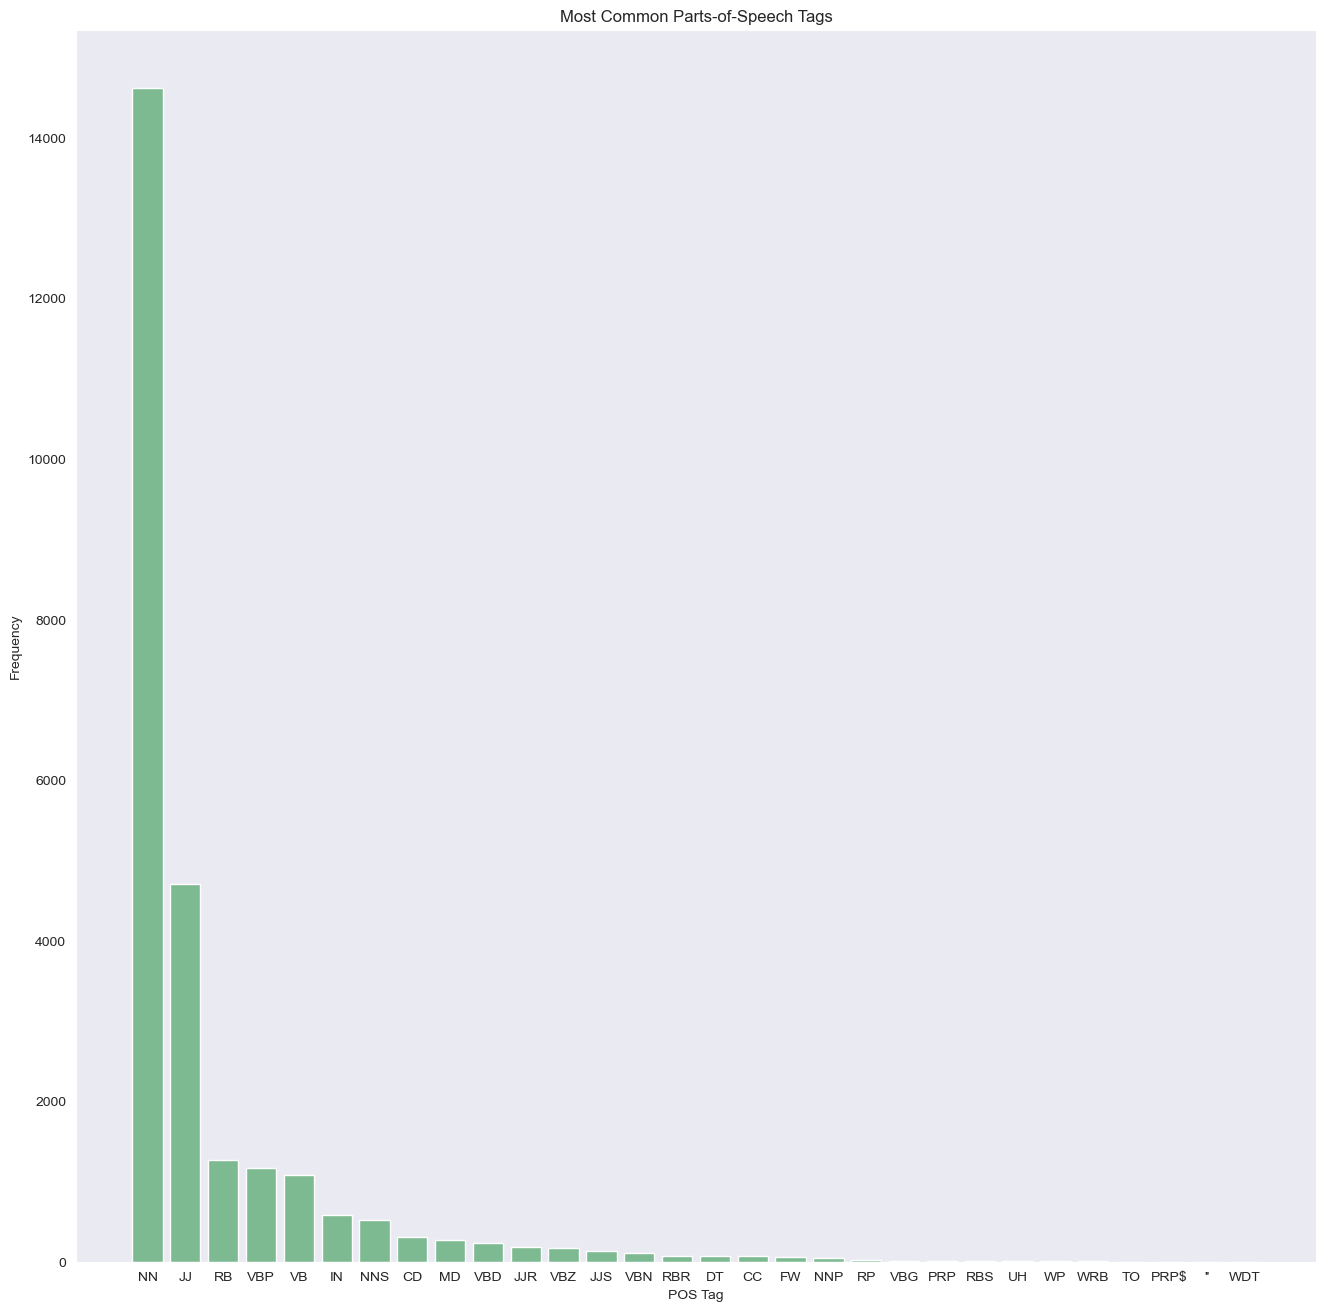

In [47]:
# Count the frequency of each POS tag
pos_counts = {}
for row in train['pos_tags']:
    for word, pos in row:
        if pos in pos_counts:
            pos_counts[pos] += 1
        else:
            pos_counts[pos] = 1

# Sort the POS tags by frequency
pos_counts = {k: v for k, v in sorted(pos_counts.items(), key=lambda item: item[1], reverse=True)}

# Create a bar chart of the POS tag frequencies
plt.figure(figsize=(16, 16))
plt.bar(pos_counts.keys(), pos_counts.values())
plt.title('Most Common Parts-of-Speech Tags')
plt.xlabel('POS Tag')
plt.ylabel('Frequency')
plt.show()

Topic modeling

In [48]:
# Create Count Vectorizer instance and Document X Term matrix (dtm)
cv = CountVectorizer(max_df=0.95, min_df=3, stop_words="english")
dtm = cv.fit_transform(train['clean_text'])

# Show the dtm in in compressed sparse Row format
dtm

<3016x1279 sparse matrix of type '<class 'numpy.int64'>'
	with 19571 stored elements in Compressed Sparse Row format>

In [49]:
# Set the number of topics
NB_TOPICS = 5 

# Creat the model
LDA_model = LatentDirichletAllocation(n_components = NB_TOPICS, 
                                      max_iter = 30, random_state = 2021)

# Fit the model on the dtm
LDA_model.fit(dtm)

LatentDirichletAllocation(max_iter=30, n_components=5, random_state=2021)

In [50]:
# Link documents to topics
final_topics = LDA_model.transform(dtm)

In [51]:
# Show the shape of the object 
print(final_topics.shape)

(3016, 5)


Apply the same methodology to the test dataset.

In [52]:
# Create Count Vectorizer instance and Document X Term matrix (dtm)
dtm_test = cv.transform(test['clean_text'])
final_topics_test = LDA_model.transform(dtm_test)

In [53]:
# Create a dataframe from the final_topics 
train["Topic N°"] = final_topics.argmax(axis=1)
test["Topic N°"] = final_topics_test.argmax(axis=1)

In [54]:
# Show 5 first documents and their associated topics
train.head()

,train_idx,text,label,label_text,clean_text,message_len,words,pos_tags,Topic N°
0,0,i really do recommend this to anyone in need o...,1,positive,realli recommend anyon need new player,6,"[realli, recommend, anyon, need, new, player]","[(realli, JJ), (recommend, NN), (anyon, NNS), ...",0
1,1,very good every day camera fits nicely in the ...,1,positive,good everi day camera fit nice pocket jean tak...,11,"[good, everi, day, camera, fit, nice, pocket, ...","[(good, JJ), (everi, NN), (day, NN), (camera, ...",0
2,2,"but , dollar for dollar , this dvd player is p...",1,positive,dollar dollar dvd player probabl best,6,"[dollar, dollar, dvd, player, probabl, best]","[(dollar, NN), (dollar, NN), (dvd, NN), (playe...",4
3,3,i got this phone yesterday and didn ' t find a...,1,positive,get phone yesterday find problem yet,6,"[get, phone, yesterday, find, problem, yet]","[(get, VB), (phone, NN), (yesterday, NN), (fin...",4
4,4,1 ) price gb of storage,1,positive,price gb storag,3,"[price, gb, storag]","[(price, NN), (gb, NNS), (storag, VBP)]",1


In [56]:
test.head()

,test_idx,text,clean_text,message_len,Topic N°
0,0,fm receiver it has none,fm receiv none,3,1
1,1,"the picture quality surprised me , when i firs...",pictur qualiti surpris first saw camera saw sm...,15,0
2,2,great video clip quality for a digital camera ...,great video clip qualiti digit camera much bet...,13,0
3,3,creative did well on its rechargeable battery ...,creativ well recharg batteri featur,5,3
4,4,i highly recommend this camera to anyone looki...,high recommend camera anyon look good digit ca...,17,0


In [57]:
panel = pyLDAvis.sklearn.prepare(LDA_model, dtm, cv)
pyLDAvis.display(panel)

C:\Users\Vladi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Vladi\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [58]:
numerical_features = train[["label", "message_len", "Topic N°"]]

In [59]:
def plot_corr_heatmap(df, threshold=0.1, method="pearson"):
    # Create a correlation matrix using the kendall method
    corr_matrix = df.corr(method)

    # Create a mask to hide the lower triangle of the matrix
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Create a new mask to show only the values above the threshold
    new_mask = np.abs(corr_matrix) < threshold
    mask = mask | new_mask

    # Create a heatmap of the correlation matrix with the modified mask
    plt.figure(figsize=(16, 16))
    sns.heatmap(corr_matrix, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm')
    plt.show()

C:\Users\Vladi\AppData\Local\Temp\ipykernel_5612\4164860291.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr(method)
C:\Users\Vladi\AppData\Local\Temp\ipykernel_5612\4164860291.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


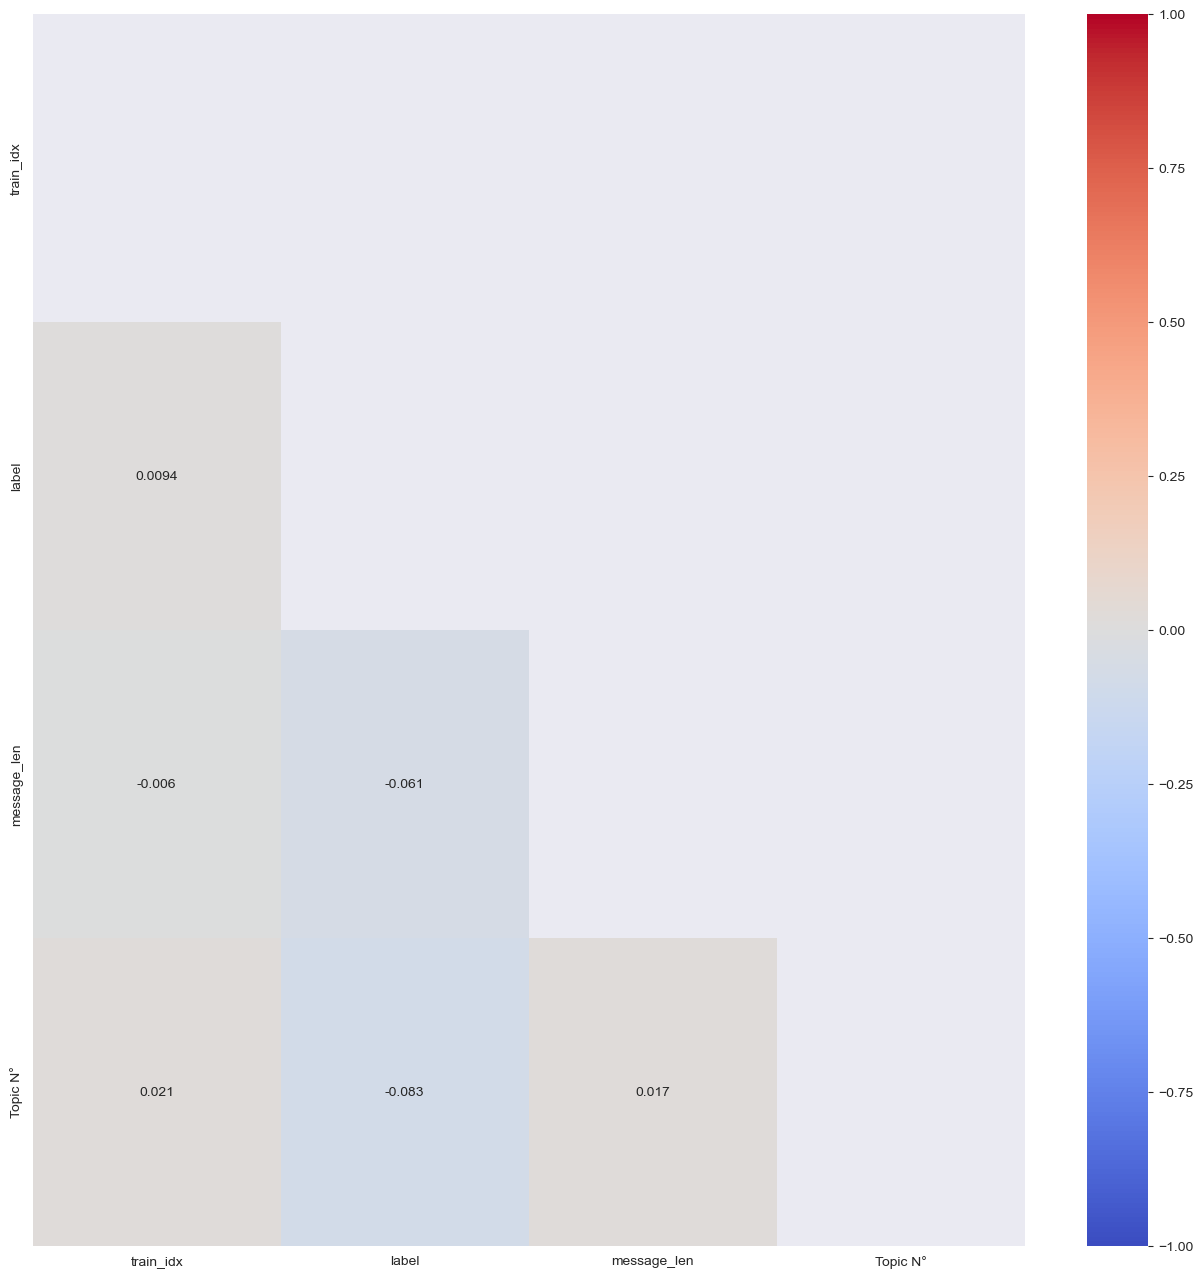

In [60]:
plot_corr_heatmap(train, threshold=0.0, method="kendall")

In [61]:
training_set, validation_set = train_test_split(train, test_size=0.2, random_state=42)
print("Training size:", len(training_set))
print("Validation size:", len(validation_set))

Training size: 2412
Validation size: 604


In [62]:
training_set.head()

,train_idx,text,label,label_text,clean_text,message_len,words,pos_tags,Topic N°
2768,2768,the interface took a little getting used to,0,negative,interfac take littl get use,5,"[interfac, take, littl, get, use]","[(interfac, NNS), (take, VBP), (littl, NN), (g...",1
2583,2583,loved the slim design,1,positive,love slim design,3,"[love, slim, design]","[(love, VB), (slim, NN), (design, NN)]",0
1406,1406,while the software may not be as easy as i tun...,0,negative,softwar may easi tune difficult use stretch,7,"[softwar, may, easi, tune, difficult, use, str...","[(softwar, NN), (may, MD), (easi, VB), (tune, ...",1
3011,3011,"as for itunes , i don ' t find it to be as goo...",1,positive,itun find good window media player comput play...,10,"[itun, find, good, window, media, player, comp...","[(itun, JJ), (find, RB), (good, JJ), (window, ...",4
2002,2002,"i have it for a week now , and this camera has...",1,positive,week camera exceed expect,4,"[week, camera, exceed, expect]","[(week, NN), (camera, NN), (exceed, VBP), (exp...",2


In [63]:
test.head()

,test_idx,text,clean_text,message_len,Topic N°
0,0,fm receiver it has none,fm receiv none,3,1
1,1,"the picture quality surprised me , when i firs...",pictur qualiti surpris first saw camera saw sm...,15,0
2,2,great video clip quality for a digital camera ...,great video clip qualiti digit camera much bet...,13,0
3,3,creative did well on its rechargeable battery ...,creativ well recharg batteri featur,5,3
4,4,i highly recommend this camera to anyone looki...,high recommend camera anyon look good digit ca...,17,0


##### Word Embedding Visualization

In [64]:
documents = [clean_text.split() for clean_text in training_set.clean_text] 

In [65]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=w2v_size, 
                                            window=w2v_window, 
                                            min_count=w2v_min_count, 
                                            workers=8)

In [66]:
w2v_model.build_vocab(documents)

In [67]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=w2v_epoch)

CPU times: total: 1.02 s
Wall time: 590 ms


(383625, 667584)

In [68]:
# Create a matrix of embeddings
words = list(w2v_model.wv.key_to_index)
embedding_matrix = w2v_model.wv[words]

In [69]:
# Reduce dimensionality of embedding
pca = PCA(n_components=50)
embedding_matrix_reduced = pca.fit_transform(embedding_matrix)

In [70]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, verbose=2)
tsne_embedding = tsne.fit_transform(embedding_matrix_reduced)

C:\Users\Vladi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vladi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 493 samples in 0.001s...
[t-SNE] Computed neighbors for 493 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 493 / 493
[t-SNE] Mean sigma: 0.235050
[t-SNE] Computed conditional probabilities in 0.011s
[t-SNE] Iteration 50: error = 63.3076630, gradient norm = 0.5271598 (50 iterations in 0.086s)
[t-SNE] Iteration 100: error = 65.5273209, gradient norm = 0.4935665 (50 iterations in 0.073s)
[t-SNE] Iteration 150: error = 65.7502747, gradient norm = 0.4987172 (50 iterations in 0.099s)
[t-SNE] Iteration 200: error = 66.1895065, gradient norm = 0.4845544 (50 iterations in 0.075s)
[t-SNE] Iteration 250: error = 65.6518097, gradient norm = 0.4824021 (50 iterations in 0.075s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.651810
[t-SNE] Iteration 300: error = 0.8238647, gradient norm = 0.0027077 (50 iterations in 0.063s)
[t-SNE] Iteration 350: error = 0.7936141, gradient norm = 0.0005435 (

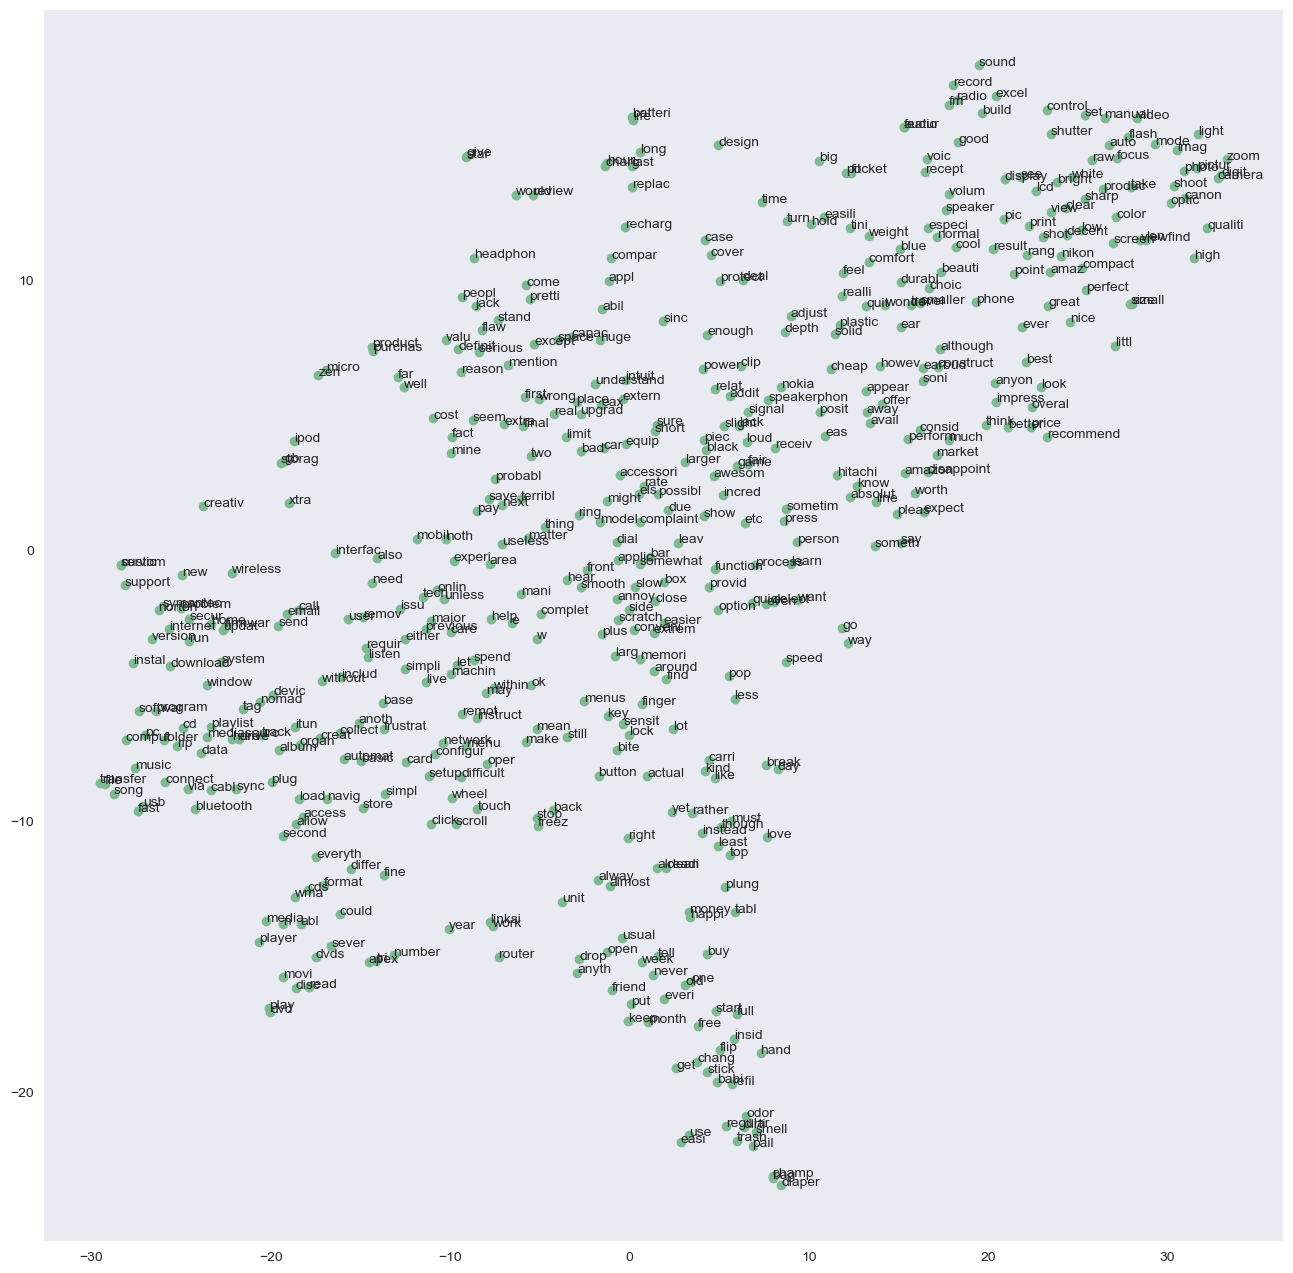

In [71]:
# Plot the embeddings
plt.figure(figsize=(16, 16))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(tsne_embedding[i, 0], tsne_embedding[i, 1]))
plt.show()

T-SNE without PCA

In [72]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, verbose=2)
tsne_embedding = tsne.fit_transform(embedding_matrix)

C:\Users\Vladi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Vladi\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 493 samples in 0.000s...
[t-SNE] Computed neighbors for 493 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 493 / 493
[t-SNE] Mean sigma: 0.235312
[t-SNE] Computed conditional probabilities in 0.012s
[t-SNE] Iteration 50: error = 66.2376556, gradient norm = 0.4940330 (50 iterations in 0.090s)
[t-SNE] Iteration 100: error = 67.1820679, gradient norm = 0.4947762 (50 iterations in 0.080s)
[t-SNE] Iteration 150: error = 66.0752106, gradient norm = 0.4977747 (50 iterations in 0.080s)
[t-SNE] Iteration 200: error = 65.0803986, gradient norm = 0.5150037 (50 iterations in 0.074s)
[t-SNE] Iteration 250: error = 67.0690842, gradient norm = 0.4878727 (50 iterations in 0.081s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.069084
[t-SNE] Iteration 300: error = 0.8567246, gradient norm = 0.0026525 (50 iterations in 0.070s)
[t-SNE] Iteration 350: error = 0.8295033, gradient norm = 0.0004231 (

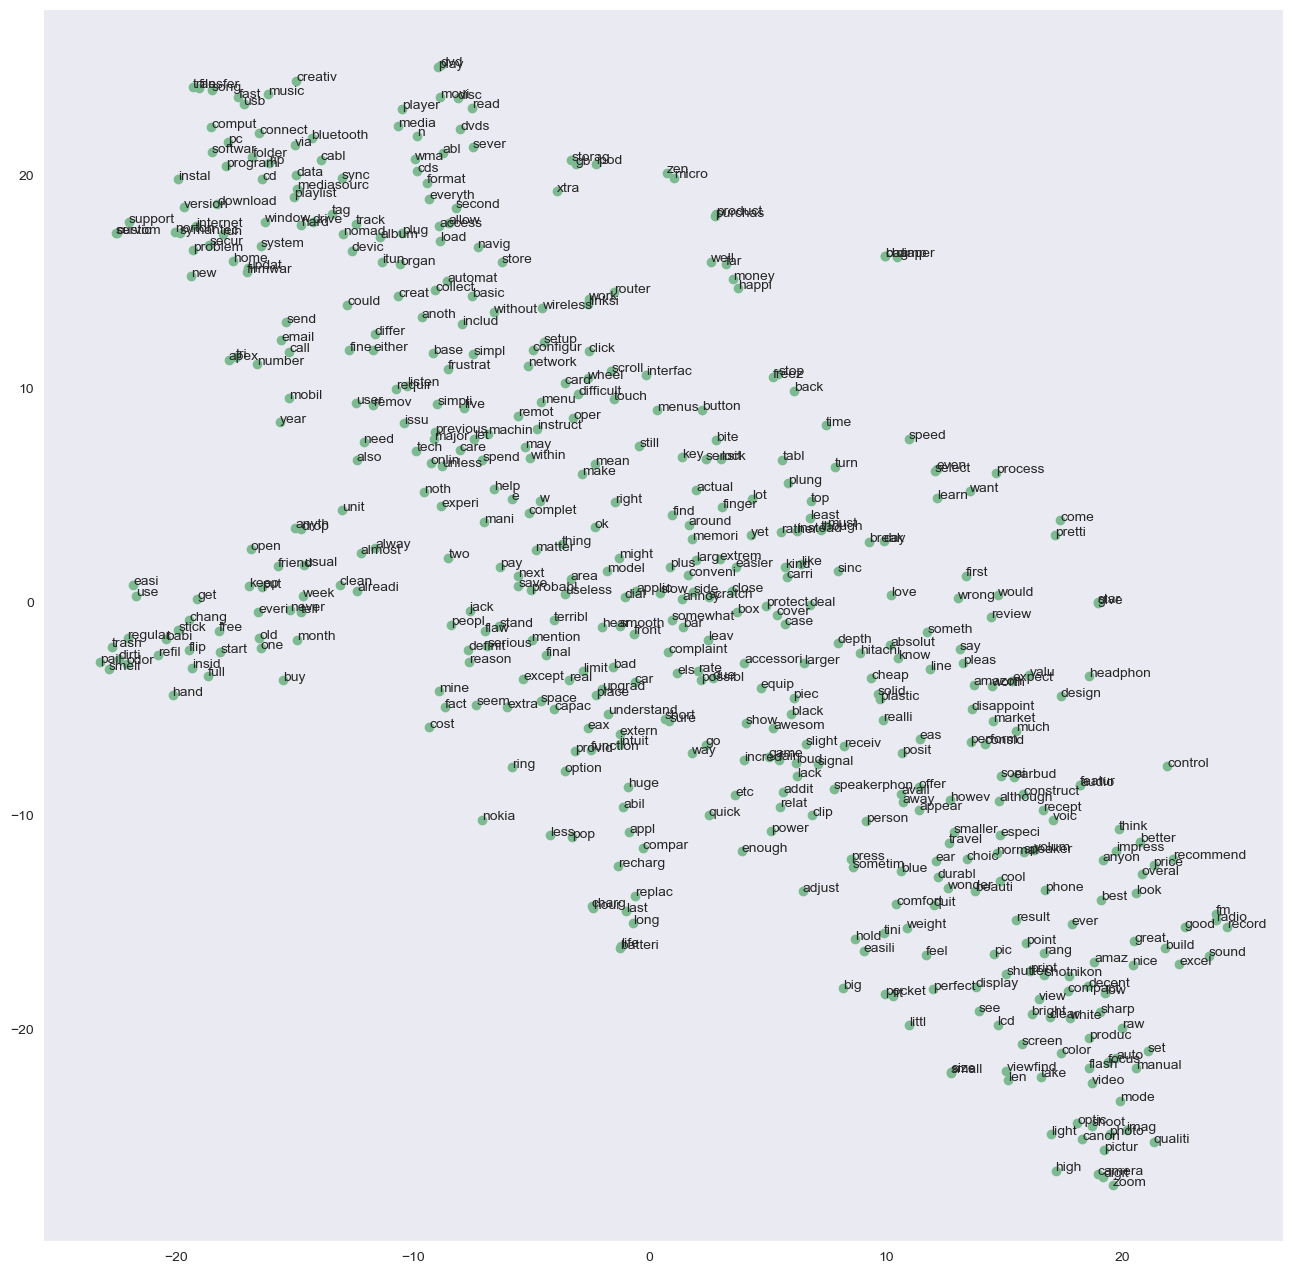

In [73]:
# Plot the embeddings
plt.figure(figsize=(16, 16))
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(tsne_embedding[i, 0], tsne_embedding[i, 1]))
plt.show()

##### Model

In [74]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_set.clean_text)

CPU times: total: 31.2 ms
Wall time: 30 ms


In [75]:
vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 2781


In [76]:
%%time
X_train_text = pad_sequences(tokenizer.texts_to_sequences(training_set.clean_text), maxlen=sequence_length)
X_val_text = pad_sequences(tokenizer.texts_to_sequences(validation_set.clean_text), maxlen=sequence_length)
X_test_text = pad_sequences(tokenizer.texts_to_sequences(test.clean_text), maxlen=sequence_length)

CPU times: total: 46.9 ms
Wall time: 48 ms


In [77]:
labels = training_set.label.unique().tolist()
# labels.append(NEUTRAL)
labels

[0, 1]

In [78]:
encoder = LabelEncoder()
encoder.fit(training_set.label.tolist())

LabelEncoder()

In [79]:
y_train = encoder.transform(training_set.label.tolist())
y_val = encoder.transform(validation_set.label.tolist())

In [80]:
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [81]:
model_features = ["message_len", "Topic N°"]
X_train_features = training_set[model_features]
X_val_features = validation_set[model_features]
X_test_features = test[model_features]

In [83]:
print("X_train_text", X_train_text.shape)
print("y_train", y_train.shape)
print()
print("X_val_text", X_val_text.shape)
print("y_val", y_val.shape)
print()
print("X_test_text", X_test_text.shape)

X_train_text (2412, 300)
y_train (2412, 1)

X_val_text (604, 300)
y_val (604, 1)

X_test_text (754, 300)


##### Model

Glove

In [84]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(embedding_file, encoding="utf8"))

In [85]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

C:\Users\Vladi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [86]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [87]:
embedding_layer = Embedding(len(word_index), embedding_dim, weights=[embedding_matrix],\
                            input_length=sequence_length, trainable=False)

In [88]:
# Define the input layer for the additional features
input_layer = Input(shape=(2,))

In [89]:
%%time
# Define the model
input_text = Input(shape=(sequence_length,))
embedded_text = embedding_layer(input_text)

lstm_output1 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(embedded_text)
lstm_output2 = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(lstm_output1)
concatenated_output = Concatenate()([lstm_output2, input_layer])
hidden_layer = Dense(50, activation='relu')(concatenated_output)
output = Dense(1, activation='sigmoid')(hidden_layer)

model = Model(inputs=[input_text, input_layer], outputs=output)

CPU times: total: 1.27 s
Wall time: 3.16 s


<!-- # Define the model
input_text = Input(shape=(sequence_length,))
embedded_text = embedding_layer(input_text)
lstm_output = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(embedded_text)
concatenated_output = Concatenate()([lstm_output, input_layer])
output = Dense(1, activation='sigmoid')(concatenated_output)
model = Model(inputs=[input_text, input_layer], outputs=output) -->

<!-- sequence_length = 300
epochs = 8
batch_size = 1024 -->

<!-- model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid')) -->

In [90]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     834000      ['input_2[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 300, 256)     439296      ['embedding[0][0]']              
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         164352      ['bidirectional[0][0]']          
 )                                                                                            

In [91]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

In [92]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [93]:
%%time
history = model.fit([X_train_text, X_train_features],
          y_train,
          validation_data=([X_val_text, X_val_features], y_val),
          epochs=epochs, batch_size=batch_size)

Epoch 1/10
19/19 [==============================] - 231s 12s/step - loss: 0.6460 - accuracy: 0.6347 - val_loss: 0.6124 - val_accuracy: 0.6772
Epoch 2/10
19/19 [==============================] - 220s 12s/step - loss: 0.5769 - accuracy: 0.6944 - val_loss: 0.5683 - val_accuracy: 0.6871
Epoch 3/10
19/19 [==============================] - 224s 12s/step - loss: 0.5030 - accuracy: 0.7546 - val_loss: 0.5120 - val_accuracy: 0.7616
Epoch 4/10
19/19 [==============================] - 227s 12s/step - loss: 0.4583 - accuracy: 0.7840 - val_loss: 0.5124 - val_accuracy: 0.7467
Epoch 5/10
19/19 [==============================] - 220s 12s/step - loss: 0.4400 - accuracy: 0.7968 - val_loss: 0.5030 - val_accuracy: 0.7699
Epoch 6/10
19/19 [==============================] - 222s 12s/step - loss: 0.3988 - accuracy: 0.8250 - val_loss: 0.5166 - val_accuracy: 0.7599
Epoch 7/10
19/19 [==============================] - 231s 12s/step - loss: 0.3718 - accuracy: 0.8396 - val_loss: 0.4875 - val_accuracy: 0.7583
Epoch 

<!-- %%time
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks) -->

<!-- %%time
score = model.evaluate(x_val, y_val, batch_size=batch_size)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0]) -->

In [94]:
# Evaluate the model on the validation set
score = model.evaluate([X_val_text, X_val_features], y_val, batch_size=batch_size)
print("Validation Accuracy:", round(score[1], 2))
print("Validation Loss:", round(score[0], 2))

5/5 [==============================] - 6s 1s/step - loss: 0.5257 - accuracy: 0.7666
Validation Accuracy: 0.77
Validation Loss: 0.53


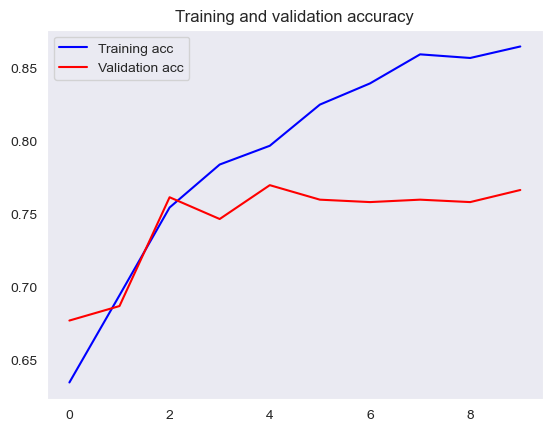

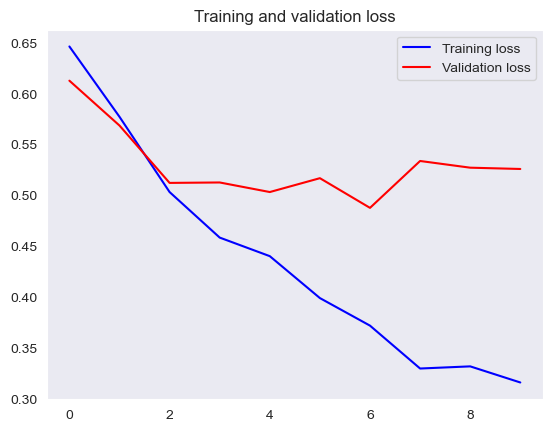

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [107]:
# Make predictions on the test set
probabilities = model.predict([X_test_text, X_test_features], batch_size=batch_size)

In [118]:
probabilities[:5]

array([[0.61397827],
       [0.9116863 ],
       [0.9890655 ],
       [0.7512751 ],
       [0.97755903]], dtype=float32)

In [116]:
# Set the threshold
threshold = 0.5

# Convert the predicted probabilities to binary predictions
y_test_pred = np.where(probabilities > threshold, 1, 0)

In [119]:
y_test_pred[:5]

array([[1],
       [1],
       [1],
       [1],
       [1]])

In [122]:
# Create a DataFrame with predicted binary classes and index from test set
results_df = pd.DataFrame({"target": y_test_pred.flatten()})

In [123]:
# Save the predictions to CSV file
results_df.to_csv('predictions.csv')

In [124]:
# Save the predictions to JSON file
results_df.to_json('predictions.json')